Task #11
=======

In [8]:
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as sps
import matplotlib.pyplot as plt
import math
import queue
sns.set_theme()


#11.1
----

In [13]:
def simulateQue(t, s, T):
    q_state = [0]
    q_t = [0]
    
    def add_state(t, a):
        q_state.append(q_state[-1] + a)
        q_t.append(t)
    
    n = t.shape[0]
    q = queue.Queue()
    for i in range(0, n):
        if (q.empty()):
            q.put(s[i])
            curr_time = t[i]
            j = i + 1
            add_state(curr_time, +1)
        dt = q.get()
        while (j < n) and (t[j] < curr_time + dt):
            q.put(s[j])
            add_state(t[j], +1)
            j += 1
        curr_time += dt
        add_state(curr_time, -1)
    q_t = np.array(q_t)
    q_state = np.array(q_state)
    return q_t[q_t <= T], q_state[q_t <= T]

def getHomQue(lmb, T):
    N = int(1e5)
    t = np.random.exponential(1 / lmb, N).cumsum()
    while(t[-1] < T):
        t = np.append(t, np.random.exponential(1 / lmb, N).cumsum())
    t = t[t < T]
    n = t.shape[0]
    s = (np.random.normal(0, 1, [n, 10]) ** 2).sum(axis=1)
    return t, s
    
def getHomQueSimulation(lmb, T):
    t, s = getHomQue(lmb, T)
    return simulateQue(t, s, T)

Text(0, 0.5, 'n(t)')

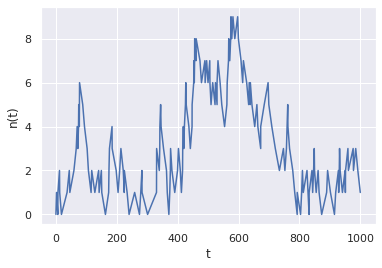

In [14]:
T = int(1000)
l = 0.10
t, n = getHomQueSimulation(l, T)
plt.plot(t, n)
plt.xlabel("t")
plt.ylabel("n(t)")

#11.2
----

In [15]:
intens = lambda t: (1 + np.cos(t))
def getCycledQue(lmb0, T):
    t, s = getHomQue(lmb0, T)
    prob = intens(t) / 2
    ind = np.argwhere(np.random.binomial(1, prob, prob.shape[0]) == 1).reshape(-1)

    return simulateQue(t[ind], s[ind], T)

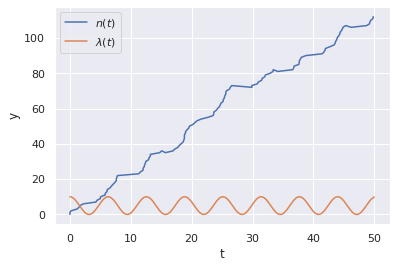

In [17]:
T = int(50)
lmb = 5
t, n = getCycledQue(lmb, T)
plt.plot(t, n)
x = np.linspace(0, T, int(1e5))

plt.plot(x, lmb * intens(x))
plt.xlabel("t")
plt.ylabel("y")
plt.legend([r'$n(t)$', r'$\lambda(t)$'])

#11.3
----

In [18]:
def getPareto(xm, k, n):
    return xm / (np.random.uniform(0, 1, n) ** (1/k))
    
def getInsCases(lmb, T, xm, k):
    N = int(1e5)
    t = np.random.exponential(1 / lmb, N).cumsum()
    while(t[-1] < T):
        t = np.append(t, np.random.exponential(1 / lmb, N).cumsum())
    t = t[t < T]
    n = t.shape[0]

    s = getPareto(xm, k, n)
    return t, s

def getS(lmb, T, xm, k):
    t_case, s = getInsCases(lmb, T, xm, k)
    def S1(t):
        T_CASE, T = np.meshgrid(t_case, t)
        pay = np.repeat(s.reshape(1, s.shape[0]), t.shape[0], axis=0)
        # print(T_CASE)
        T_CASE[T_CASE > T] = 0
        T_CASE[T_CASE != 0] = 1
        # print(T_CASE)
        return np.sum(pay * T_CASE, axis=1)
    def S(t):
        MAX_SIZE = int(1e7)
        res = np.zeros(t.shape)
        chunk_size = MAX_SIZE // t_case.shape[0]
        l, r = 0, 0
        while (l < t.shape[0]):
            r = min(r + chunk_size, t.shape[0])
            res[l:r] = S1(t[l:r])
            l += chunk_size
        return res
    return S

def getW(W0, c, S):
    def W(t):
        res = W0 + c * t - S(t)
        bankrupt = np.argwhere(res <= 0)
        if (bankrupt.any()):
            bankrupt = int(bankrupt[0])
            res[bankrupt:] = 0
        return res
    return W

Text(0, 0.5, 'W_t')

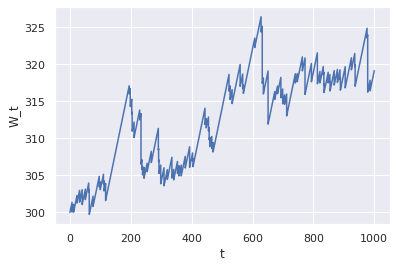

In [21]:
l, xm, k, c = 0.1, 1, 2, 0.2
W0 = 300
T = 1000
S = getS(l, T, xm, k)
W = getW(W0, c, S)

t = np.linspace(0, T, int(1e5))

plt.plot(t, W(t))
plt.xlabel("t")
plt.ylabel("W_t")
